# Performance Metrics for Classification 
Note: This notebook is adapted from [Geron's chapter 3 notebook](https://github.com/ageron/handson-ml3/blob/main/03_classification.ipynb) in accordance with the [Apache v2 License](https://github.com/ageron/handson-ml3/blob/main/LICENSE).

This assignment makes use of the MNIST Database as its dataset. It is a sizable collection of handwritten numbers that is frequently utilized to train different image processing programs. Additionally, the database is frequently used for machine learning testing and training. By "re-mixing" the samples from the original NIST datasets, it was created.


First let's load all of the libraries that will be used as part of this notebook:

In [19]:
import numpy as np

# plotting modules
from matplotlib import pyplot as plt
import matplotlib.patches as patches  # for curved arrows
import seaborn as sns

# The web source of the MNIST dataset that we will work with
from sklearn.datasets import fetch_openml

# Preprocessing 
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import scale

# The classifiers we will use in this notebook
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
# Train test split
from sklearn.model_selection import train_test_split

# performance metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score, recall_score


## Obtaining the Data
We load the data from `openml.org`. [openml.org](https://openml.org/) is a public repository for machine learning data and experiments, that allows everybody to upload open datasets.The `sklearn.datasets` package is able to download datasets from the repository using the function `sklearn.datasets.fetch_openml` ([sklearn User Guide](https://scikit-learn.org/stable/datasets/loading_other_datasets.html#openml), [sklearn docs](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_openml.html)).

##### About the Openml.org :

Machine learning research that is easily accessible and reusable is required. OpenML is an open platform for sharing experiments, datasets, and algorithms with the aim of learning how to learn better together.  

The 5.6k dataset collection on the website, the 261.5k tasks, and the 17.2k flows on Tasks are benchmarked against other machine learning evaluations. OpenML includes a number of collections, documentations, and task-understanding procedures. Both Python and R are supported on this page.

The dataset description found in the [Wikipedia article](https://en.wikipedia.org/wiki/MNIST_database) 
Explains that the dataset has 60,000 training images and 10,000 testing images made by "re-mixing" the samples from NIST's original datasets. The black and white images from NIST were normalized to fit into a 28x28 pixel bounding box and anti-aliased, which introduced grayscale levels. Based on the _Sample images from MNIST test dataset_, there are 10 unique digits from 0 to 9.

In [20]:
mnist = fetch_openml('mnist_784', as_frame=False, parser='auto')

The total pixel value, or 28 * 28, is represented by the number 784.

## Exploring the Data

The object that is returned back from fetch_openml is a Bunch object (docs). This is a standard sklearn object, used for storing datasets.

In [21]:
type(mnist)

sklearn.utils._bunch.Bunch

It is a dictionary-like object, with keys and values just like a standard Python dictionary in that sense. So we can print out all of its keys:

In [22]:
list(mnist)

['data',
 'target',
 'frame',
 'categories',
 'feature_names',
 'target_names',
 'DESCR',
 'details',
 'url']

By the way, the same can be achieved by:

In [23]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

The object also contains a description of the dataset that it contains. This is provided by the curators of the dataset. It can be accessed using the `DESCR` method of the object.

In [24]:
print(mnist.DESCR)

**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

Let's look into the `data` and the `target` attributes.

In [25]:
mnist.data.shape

(70000, 784)

In [26]:
mnist.target.shape

(70000,)

In [27]:
print(mnist.target[0], mnist.target[1], mnist.target[2])

5 0 4


##### Minist dataset has 7000 data shape with 784 columns. Its represents has pixels.The original {digit} that the entire row represents is represented by the {target} values. 

In [28]:
mnist.data[0,200:205]

array([  0,   0,   0,  49, 238], dtype=int64)

##### Based on the color that the pixel is filled with, the values 0, 49, and 238 represent the pixel values. The entire image of the digit will be represented by the color of each of the 784 pixels.


Let's rename these objects to our familiar conventions, that are common regardless of the specific dataset being studied:

In [29]:
X = mnist.data
y = mnist.target.astype(int)

It will be good at this point to look at actual data instance, which is a single image:

In [30]:
def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

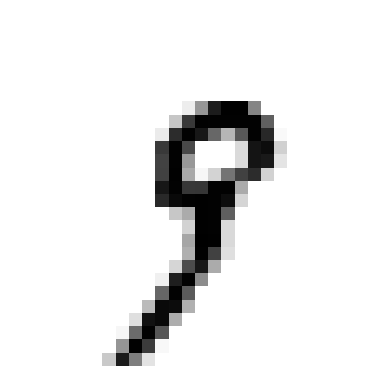

In [31]:
some_digit = X[19]  # here we are using the 20th image in the dataset
plot_digit(some_digit)
plt.show()

Looking at the image that's displayed, it looks like a 9. The target value must be predicted by our model in order for it to yield the correct result.


In [32]:
y[19]  # the label for the 20th image

9

For better famliarity with the dataset, let's plot the first 100 images.

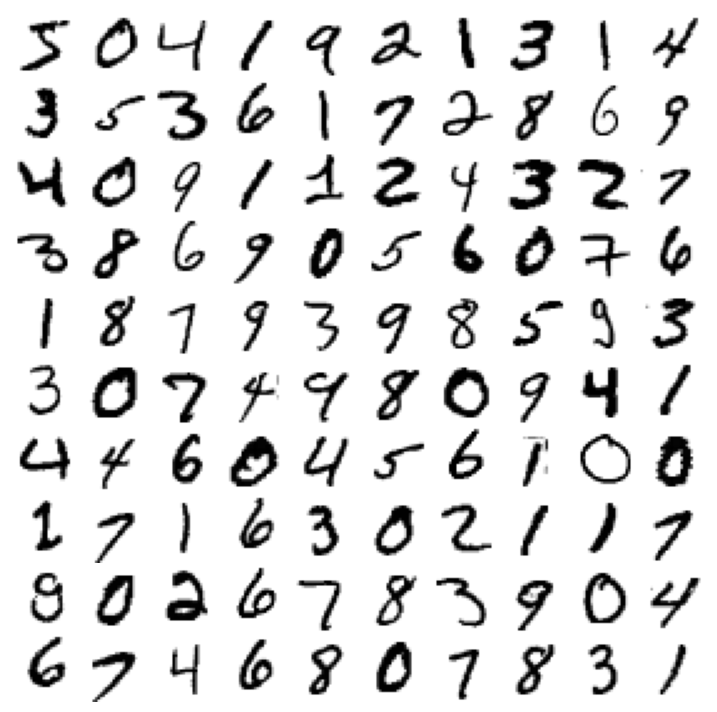

In [33]:
plt.figure(figsize=(9, 9))
for idx, image_data in enumerate(X[:100]):
    plt.subplot(10, 10, idx + 1)
    plot_digit(image_data)
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

This provides an initial familiarity with the dataset.

An important property of a classification dataset is its skewness (Wikipedia). For classification problems, the skewness is how uniform the data is in terms of the number of samples per label. In our case, it is the number of images for each digit. A uniform distribution, where each class has the same number of images, is a dataset with 0 skewness.

In [34]:
from collections import Counter

count_label = Counter(y)

# Print out the number of samples per label
for label, count in count_label.items():
    print(f"Label {label}: {count} samples")

Label 5: 6313 samples
Label 0: 6903 samples
Label 4: 6824 samples
Label 1: 7877 samples
Label 9: 6958 samples
Label 2: 6990 samples
Label 3: 7141 samples
Label 6: 6876 samples
Label 7: 7293 samples
Label 8: 6825 samples


##### Based on the target values, the statistics of how many images label a digit are provided above. Out of the 70000 images, there are approximately 7000 samples for each digit, indicating a reasonably balanced rather than highly skewed sample distribution.


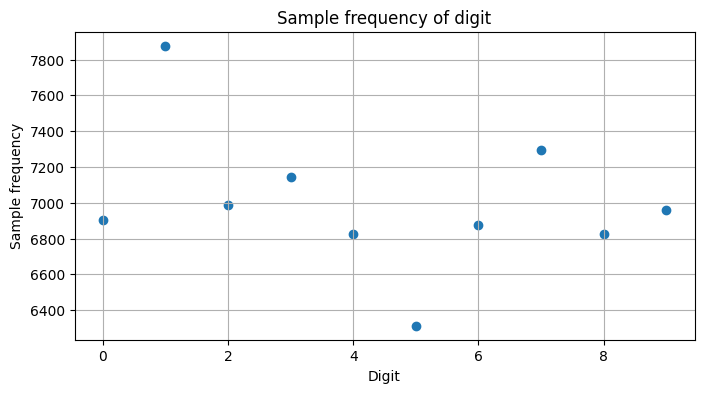

In [35]:

# Count the frequency of each digit
unique_digits, digit_counts = np.unique(y, return_counts=True)

# Create scatter plot
plt.figure(figsize=(8, 4))
plt.scatter(unique_digits, digit_counts, marker='o')
plt.xlabel('Digit')
plt.ylabel('Sample frequency')
plt.title('Sample frequency of digit')
plt.grid(True)  # Add grid lines for better readability
plt.show()


The Scatter plot graph shows how except for the digit 1, all the sample values are evenly distributed.

## Split the data into Training and Testing set

The data will now be divided into training and validation sets in order to begin preparing it for additional analysis. We'll carry out preprocessing operations like scaling, eliminating anomalies, and enhancing the data by generating comparable samples by utilizing preexisting ones. We will separate the data into a training set and a test set, and create new labels for each, as an alternative to employing a 10-fold classification approach. Of the total data, 20% will be used for testing and the remaining 20% for validation. For training, the remaining 80% will be utilized.


In [37]:
X_scaled = scale(X)
X_data_train, X_data_temp, y_data_train, y_data_temp = train_test_split(X_scaled, y, test_size=0.4, random_state=42)
X_data_val, X_data_test, y_data_val, y_data_test = train_test_split(X_data_temp, y_data_temp, test_size=0.5, random_state=42)

## Training a Model

Here we are using the stocastic gradient descent classifier ([docs](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html)). It provides SGD training of linear classifiers (SVM, logistic regression, etc.). However, we will not focus in this notebook on _how_ the classifer works internally, but on how well it performs. 

In [40]:
logistic_reg = LogisticRegression(max_iter=1000)
logistic_reg.fit(X_data_train, y_data_train)

LogisticRegression(max_iter=1000)

## Model Evaluation

We will first evaluate the model with the validation set and then proceed to finding the accuracy, confusion metric, precision, recall and F1 for each class.

In [41]:
y_val_pred = logistic_reg.predict(X_data_val)

### Accuracy

Let's start with `accuracy` as a performance metric. In `sklearn`, a performance metric is also known as `scoring metric`, and its value as `score`.

`Accuracy` is the ratio between correct perdictions to all predictions ([Wikipedia](https://en.wikipedia.org/wiki/Accuracy_and_precision#In_binary_classification)). 

$accuracy = \frac{correct\ classifications}{all\ classifications}$

In our case, the accuracy is calculated over the test set for each of the cross validation folds. Aaccuracy, like other performance metrics, can be calculated on any part of the complete dataset, including the traning set. So whenever we report about its value, it is informative to mention on which part of the dataset it was calculated on. 

Some optional `sklearn` resources about accuracy:

https://scikit-learn.org/stable/modules/model_evaluation.html#accuracy-score

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html

https://scikit-learn.org/stable/modules/model_evaluation.html#common-cases-predefined-values

In [42]:
accuracy = accuracy_score(y_data_val, y_val_pred)
print(accuracy)

0.9089285714285714


90.89% of the model is accurate. This is not the best accuracy value, as even a dummy classifier can predict with 90% accuracy.


### Confusion Matrix

To understand what a confusion matrix is, it is useful to start with an example. Wikipedia provides us with a [good one]([Wikipedia](https://en.wikipedia.org/wiki/Confusion_matrix)), let's go over it together...


In a binary classification, for a single prediction of one sample, there are 4 possible options for the prediction with respect to the _target label_ (`5` in our example, the target can be chosen from the two labels, based on our interest, based for instance on the main objective of the classifier):

the positive class is one of the two classes in a binary classification problem. It is the class that the model is trying to predict. The choice of which class is considered positive and which is considered negative is often arbitrary and depends on the context of the problem. For example, in a medical test for a disease, the positive class could be “disease present” and the negative class could be “disease not present”.

There are two types of correct predictions:
* **True Positive** - the prediction is of the target class, and that is correct (according to the ground truth). 
* **True Negative** - the prediction is not of the target class, and this is correct.

There are two types of incorrect predictions:
* **False Positive** - the prediction is of the target class, and this is incorrect (according to the ground truth).
* **False Negative** - the prediction is not of the target class, and this is incorrect

The confusion matrix is a table:
* Each row stands for an actual label (going over all labels in the dataset, one row per label)
* Each column stands for a predicted label (going over all labels in the dataset, one row per label)
* Each cell in the table simply counts the number of samples in the dataset that had such a predicted-actual combination. This can be augmented by a percentage, where this number is divided by the total number of samples in the dataset.

Resources to confusion metric:

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html

https://scikit-learn.org/stable/modules/model_evaluation.html#confusion-matrix

In [43]:
#Confusion Martix
con_matrix = confusion_matrix(y_data_val, y_val_pred)
print(con_matrix)

[[1277    1   16    2    7   20   18    3   12    3]
 [   0 1507    5   11    2    6    0    3   15    3]
 [  17   17 1234   21   16   13   21   26   29    9]
 [  14    8   37 1229    4   42    9   15   15   19]
 [   7    6   11    4 1215    6   10   12    7   44]
 [   9   10    8   46   14 1135   23    4   33   13]
 [   8    3   27    4   21   18 1327    3    4    0]
 [   6    9   21   14   12    4    1 1384    3   43]
 [  13   19   24   41    8   48   16    3 1146   28]
 [   4    8    5   23   38    8    0   49   13 1271]]


## Precision, Recall and F1 for each class

#### Precision and Recall

In classification, precision and recall are additional performance metrics ([Wikipedia](https://en.wikipedia.org/wiki/Precision_and_recall)).
They are calculated and presented with respect to the 'class of interest'. This class can be any one that we are interested in calculating precision and recall for. It depends on the success criteria that we have defined for the model. For instance, if the model should identify a risk of an illness based on a medical test results, the class of interest would probably be existence of such medical condition. We call this class of interest as the _positive class_. 

* Precision is ratio of the number of correctly labelled positive samples, out of all samples labelled as positive samples. It tells us how precise the model is in predicting a positive class. This is equal to: $precision = \frac{True \ Positives}{True \ Positives + False \ Positives}$. Since precision and recall are often used in estimating the relevance of search results (think Google), precision is sometimes defined as 'the fraction of relevant instances among the retrieved instances', which stands for the same ratio.
* Recall (also known as sensitivity) is the number of correctly labelled positive samples, out of all positive samples in the test dataset $Recall = \frac{True \ Positives}{True \ Positives + False \ Negatives}$. It tells us how many samples of the 'class of interest' the model is able to identify, out of all samples. That is, how many it is able to recall. In the search relevnce jargon, this is described as the ratio of relevant instances that were retrieved, but the formula is the same.

Note that it is possible to calculate precision and recall for more than one class. If there is a need to present either precision or recall for more than one class, one can do that without issue.

The _precision and recall_ image in Wikipedia is an effective way to understand these definitions. 

See also [SKLearn User Guide](https://scikit-learn.org/stable/modules/model_evaluation.html#precision-recall-f-measure-metrics)

#### F1-score

It can be useful to compare classifiers based on a single number, that encompases both precision and recall. F1-score is a common such performance metrix. 

The F-score is calculated from the precision and recall of the test. The F1 score is the harmonic mean of the precision and recall (harmonic mean is the average of rates ([Wikipedia](https://en.wikipedia.org/wiki/Harmonic_mean)), see more below). The highest possible value of an F-score is 1.0, indicating perfect precision and recall, and the lowest possible value is 0, if either precision or recall are zero. ([Wikipedia](https://en.wikipedia.org/wiki/F-score)). Whereas the regular (arithmetic) mean treats all values equally, the harmonic mean gives more weight to low values. As a result, the classifier will only get a high F1  score if both recall and precision are high.

$F1 \ score = \frac{2}{\frac{1}{precision} + \frac{1}{recall}} = 2 \cdot \frac{precision \cdot recall}{precision + recall} = \frac{TP}{TP + \frac{FP+FN}{2}}$

Notice that the F1 score is independent of True Negatives (TN) ([Wikipedia](https://en.wikipedia.org/wiki/F-score#Criticism)).


##### Calculating precision, F1 score, recall and others classes:

In [44]:
score_report = classification_report(y_data_val, y_val_pred, digits=3)
print(score_report)

              precision    recall  f1-score   support

           0      0.942     0.940     0.941      1359
           1      0.949     0.971     0.960      1552
           2      0.889     0.880     0.884      1403
           3      0.881     0.883     0.882      1392
           4      0.909     0.919     0.914      1322
           5      0.873     0.876     0.875      1295
           6      0.931     0.938     0.935      1415
           7      0.921     0.925     0.923      1497
           8      0.897     0.851     0.874      1346
           9      0.887     0.896     0.891      1419

    accuracy                          0.909     14000
   macro avg      0.908     0.908     0.908     14000
weighted avg      0.909     0.909     0.909     14000



## Precision Recall Curve For One Class

In Scikit-learn, the `decision_function` method is a method that is available for some classifiers, such as SVMs and logistic regression models. **It returns the "distance" of each data point to the decision boundary of the classifier.**

For binary classification, the decision boundary is a hyperplane that separates the two classes. The `decision_function` method returns the signed distance of each data point to this hyperplane. The sign of the distance indicates which side of the hyperplane the data point is on, and the magnitude of the distance indicates how far the data point is from the hyperplane.

For example, if the `decision_function` method returns a value of 2 for a particular data point, this means that the data point is on the positive side of the decision boundary and is 2 units away from the boundary. If the method returns a value of -1 for another data point, this means that the data point is on the negative side of the decision boundary and is 1 unit away from the boundary.

The `decision_function` method can be useful for analyzing the confidence of the classifier's predictions. Data points with larger absolute values of the decision function are farther from the decision boundary and are more confidently classified than data points with smaller absolute values.

The SKLearn's [precision_recall_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html) function computes precision-recall pairs for different probability thresholds. 

* Note: this implementation is restricted to the binary classification task.
* The first precision and recall values are precision=class balance and recall=1.0 which corresponds to a classifier that always predicts the positive class.
* The last precision and recall values are 1. and 0. respectively and do not have a corresponding threshold. This ensures that the graph starts on the y axis.

In [45]:
class_tar = 4
y_binary_val = (y_data_val == class_tar).astype(int)
y_scores_val = logistic_reg.decision_function(X_data_val)
precision, recall, thresholds = precision_recall_curve(y_binary_val, y_scores_val[:, class_tar])

In [46]:
print("Precision shape :",precision.shape)
print("Recall shape:",recall.shape)
print("Thresholds shape :",thresholds.shape)

Precision shape : (14001,)
Recall shape: (14001,)
Thresholds shape : (14000,)


Lets have a peek at the values of precision, recall and threshold.

In [47]:
print("Precision:", precision)
print("Recall:", recall)
print("Thresholds:",thresholds)

Precision: [0.09442857 0.09443532 0.09444206 ... 0.5        1.         1.        ]
Recall: [1.00000000e+00 1.00000000e+00 1.00000000e+00 ... 7.56429652e-04
 7.56429652e-04 0.00000000e+00]
Thresholds: [-54.44972234 -51.36760224 -48.27113963 ...  36.93705737  38.32900204
  40.3480833 ]


##### The threshold ranges from -54.4 to to 40.3. Lets consider a threshold within this range.

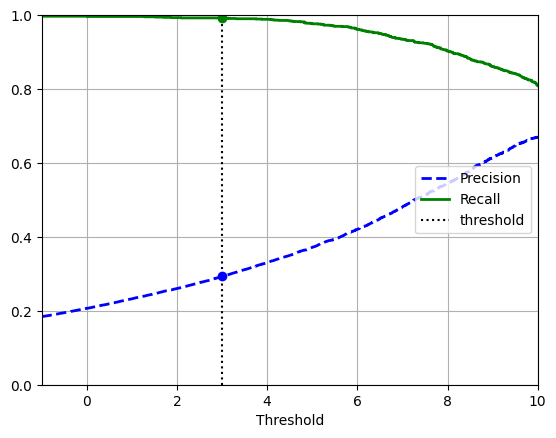

In [48]:
threshold = 3
plt.plot(thresholds, precision[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recall[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")
idx = (thresholds >= threshold).argmax()  # first index ≥ threshold
plt.plot(thresholds[idx], precision[idx], "bo")
plt.plot(thresholds[idx], recall[idx], "go")
plt.axis([-1, 10, 0, 1])
plt.grid()
plt.xlabel("Threshold")
plt.legend(loc="center right")
plt.show()

Below we use the same data, but to plot a Precision-Recall curve.
This is a useful curve for choosing a threshold. 

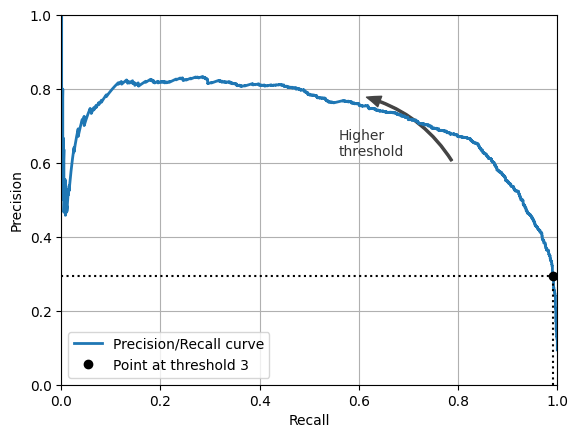

In [49]:
plt.plot(recall, precision, linewidth=2, label="Precision/Recall curve")
plt.plot([recall[idx], recall[idx]], [0., precision[idx]], "k:")
plt.plot([0.0, recall[idx]], [precision[idx], precision[idx]], "k:")
plt.plot([recall[idx]], [precision[idx]], "ko",
         label="Point at threshold 3")
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.79, 0.60), (0.61, 0.78),
    connectionstyle="arc3,rad=.2",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.56, 0.62, "Higher\nthreshold", color="#333333")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")
plt.show()

We could see that the threshold value has very low precision but higher recall. To increase the precision, the threshold value should be increased.

## Increase precision without retraining

### Precision/Recall Tradeoff, and the Decision Threshold

For a given trained classifier (without a new training), it is possible to increase the either the precision or the recall on the expense of the other. This is called the precision/recall tradeoff (note that a different classifier altogether could in principle increase both. The tradeoff is relevant only for a given classifier with a specific set of paramters).


Here, we will change the decision threshold of our binary classifier, which will change its precision and recall, without any additional training.

Let's find the threshold for a 90% precision:

In [51]:
thres_90_precision = thresholds[np.argmax(precision >= 0.90)]

print("Threshold for 90% precision:", thres_90_precision)

Threshold for 90% precision: 40.34808330272996


To validate, we can now run predictions based on the classifier's scores and the new thresholds, and to re-calculate the precision:

In [52]:
#precision
y_val_pred_90_thres = (y_scores_val >= thres_90_precision)

In [53]:
prec_score =precision_score(y_binary_val, y_val_pred_90_thres[:,class_tar])
prec_score

1.0

#### And here is the recall for that threshold:

In [54]:
#recall
recall_Score_90 = recall_score(y_binary_val, y_val_pred_90_thres[:, class_tar])
recall_Score_90

0.0007564296520423601

We achieve greater precision with this threshold values. this threshold value in order to achieve greater precision. However, we will need to consider lower threshold values in order to raise the recall above 0.0007.


## Run the tested data Values

In [55]:
y_pred_test = logistic_reg.predict(X_data_test)
test_accuracy_val = accuracy_score(y_data_test, y_pred_test)
test_conf_matrix_val = confusion_matrix(y_data_test, y_pred_test)
test_class_report_val = classification_report(y_data_test, y_pred_test)

#### Accuracy:

In [56]:
print("Test Accuracy values:", test_accuracy_val)

Test Accuracy values: 0.9106428571428572


#### Confusion Matrix

In [57]:
print("Test Confusion Matrix:\n", test_conf_matrix_val)

Test Confusion Matrix:
 [[1351    0    9    2    2   16   22    4    9    4]
 [   0 1558   11    8    2    5    3    3   15    2]
 [  12   15 1233   24   19   13   25   19   28   15]
 [   9    9   33 1264    2   49    5   16   32   18]
 [   1    6   12    2 1220    3   14    6   10   52]
 [   9    5    6   42   12 1102   26    4   37    6]
 [   5    9   19    3   13   24 1271    1    6    0]
 [   2   10   24    5   25    7    0 1364    8   43]
 [   7   34   18   37    8   44   14   14 1123   20]
 [  10    8    7    8   37    5    0   51   12 1263]]


#### Classification Report with precision, recall, f1-score

In [58]:
print("Test Classification Report:\n", test_class_report_val)

Test Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.95      0.96      1419
           1       0.94      0.97      0.96      1607
           2       0.90      0.88      0.89      1403
           3       0.91      0.88      0.89      1437
           4       0.91      0.92      0.92      1326
           5       0.87      0.88      0.88      1249
           6       0.92      0.94      0.93      1351
           7       0.92      0.92      0.92      1488
           8       0.88      0.85      0.86      1319
           9       0.89      0.90      0.89      1401

    accuracy                           0.91     14000
   macro avg       0.91      0.91      0.91     14000
weighted avg       0.91      0.91      0.91     14000



For the test set, the model predicts values with 91% accuracy. The average f1-score, average recall, and average precision are all 0.91. The model isn't the best, but it still performs well.